# 0. Load parameters


In [1]:
# | tags: [parameters]
subject = "101"

In [2]:
#| tags: [parameters]
# Injected Parameters
subject = 152


In [3]:
import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.preproc import load_data, zapline_clean, get_bad_lof
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels
from spectral.viz import plot_epochs
from spectral.specparam import specparam2pandas

import numpy as np

from spectral.ica import (
    compute_ica,
    label_components_ica,
    plot_ica_components,
    plot_removed_components,
)

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
print(raw_preproc_path)
Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]
specparam_path = my_paths["specparam_path"]
Path(specparam_path).mkdir(parents=True, exist_ok=True)


print_date_time()

Using matplotlib as 2D backend.


/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-152/
2024-04-24 22:16:41


This file contains preprocessing files after downsampling them.


# 1. Preprocess raw data


In [4]:
fline = 50
h_freq = 40
notch_freq = 50

filter_params = {
    "l_freq": 0.1,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
    "picks":['ecg', 'eeg']
}

raw = load_data(subject, project_path=project_path).resample(250)

raw_filtered = (
    raw.copy()
    .crop(tmin=0, tmax=300, include_tmax=True)
    .filter(**filter_params)
        .notch_filter(
        freqs=[notch_freq],
        phase="zero",
        method="iir"
    )
)

Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-152/ses-01/eeg/sub-152_ses-01_task-rest_eeg.set


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Filtering raw data in 2 contiguous segments


Setting up band-pass filter from 0.1 - 40 Hz


FIR filter parameters


---------------------


Designing a one-pass, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hamming window


- Lower passband edge: 0.10


- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)


- Upper passband edge: 40.00 Hz


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)


- Filter length: 16501 samples (66.004 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s


Filtering raw data in 2 contiguous segments


Setting up band-stop filter from 49 - 51 Hz


IIR filter parameters


---------------------


Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:


- Filter order 16 (effective, after forward-backward)


- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB


Setting up band-stop filter from 49 - 51 Hz


IIR filter parameters


---------------------


Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:


- Filter order 16 (effective, after forward-backward)


- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB


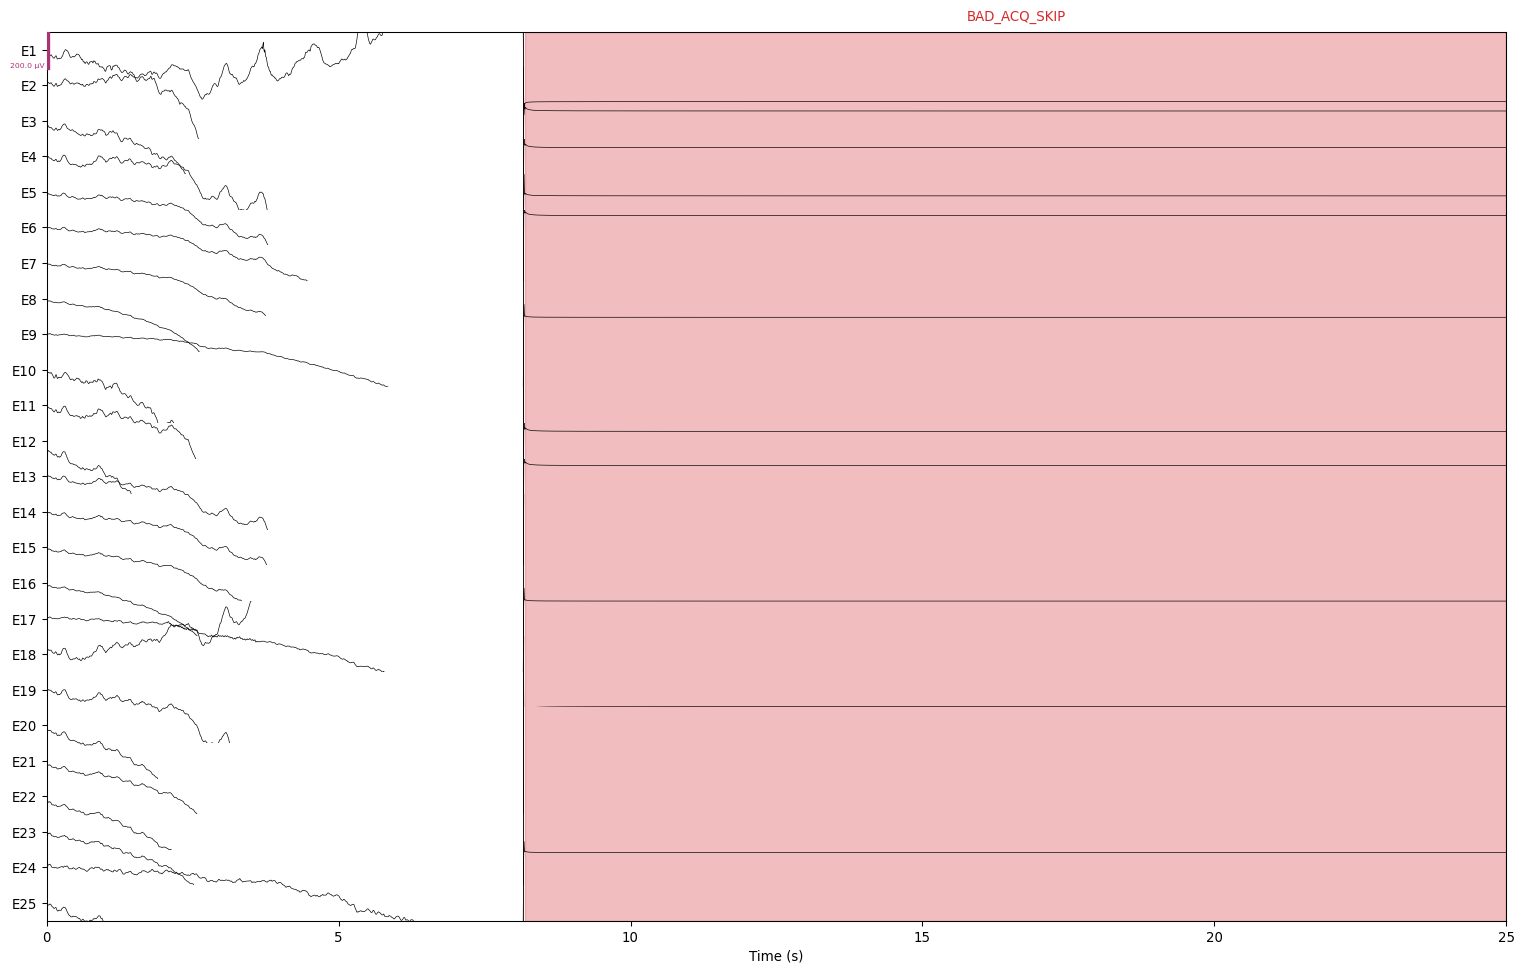

Setting 5658 of 75001 (7.54%) samples to NaN, retaining 69343 (92.46%) samples.


Effective window size : 8.192 (s)


Plotting power spectral density (dB=True).


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


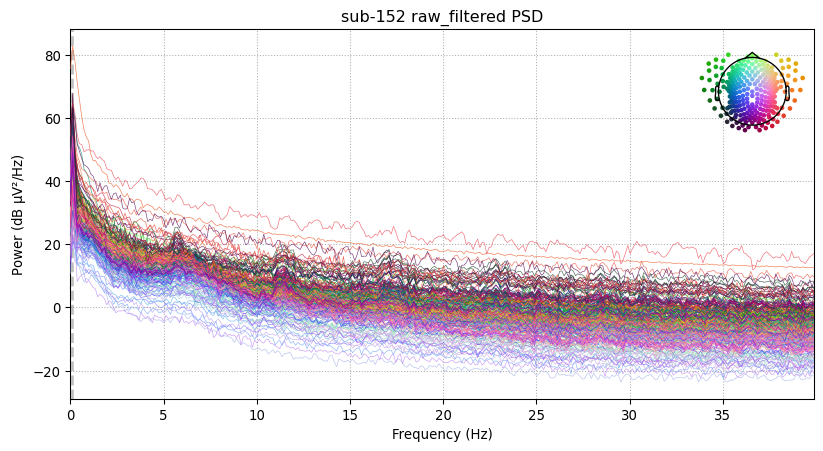

In [5]:
plot_step(
    raw_filtered,
    subject,
    figures_path,
    stage="raw_filtered",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

In [6]:
pyprep = True

if pyprep:
    bad_channels_by_ransac = apply_pyprep(
        raw_filtered, output="dict", as_dict=True
    )
else:
    bad_channels_by_ransac = get_bad_channels(raw_filtered)

raw_pyprep = raw_filtered.copy()
raw_pyprep.info["bads"].extend(bad_channels_by_ransac["bad_all"])


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Setting up high-pass filter at 1 Hz


FIR filter parameters


---------------------


Designing a one-pass, zero-phase, non-causal highpass filter:


- Windowed time-domain design (firwin) method


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 1.00


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


- Filter length: 413 samples (3.304 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...


Finding optimal chunk size : 124


Total # of chunks: 2


Current chunk:


1


2



RANSAC done!


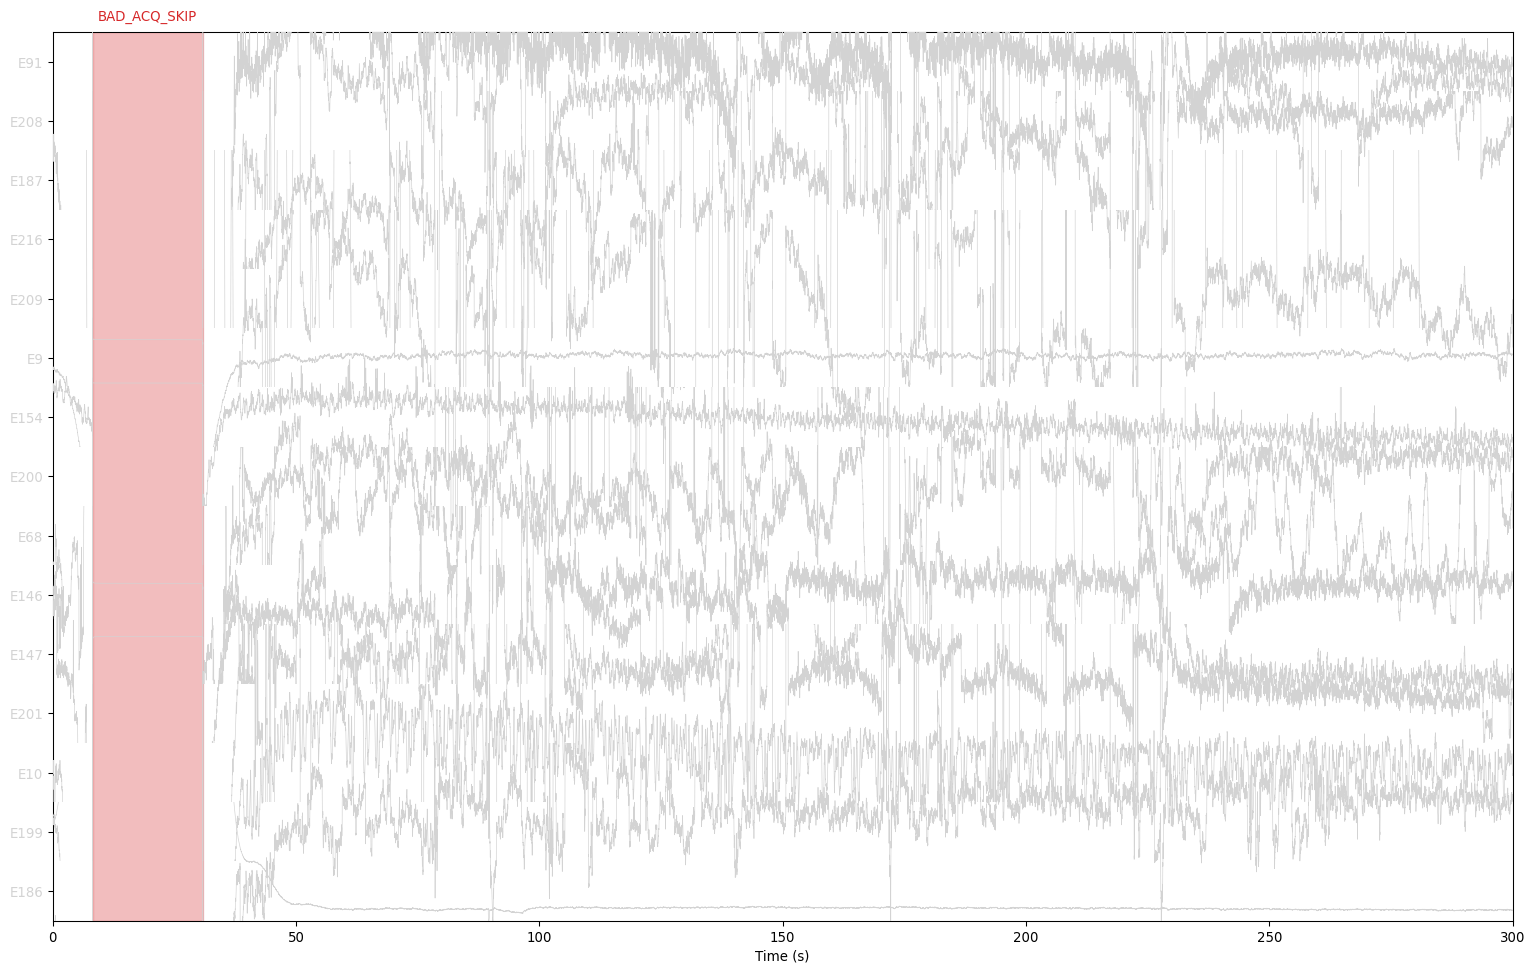

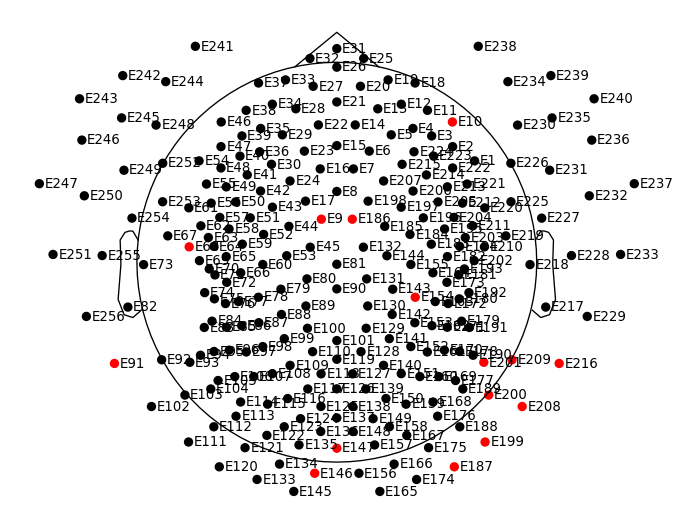

Overwriting existing file.


Writing /Users/daniel/PhD/Projects/psd-path/analysis/sub-152_filtered_raw.fif


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_48889/3983102079.py:2: RuntimeWarning: Acquisition skips detected but did not fit evenly into output buffer_size, will be written as zeroes.
  raw_pyprep.save(f'{project_path}/analysis/sub-{subject}_filtered_raw.fif', overwrite=True)


Closing /Users/daniel/PhD/Projects/psd-path/analysis/sub-152_filtered_raw.fif


[done]


In [7]:
_ = plot_bad_channels( raw_pyprep, subject, figures_path=figures_path)
raw_pyprep.save(f'{project_path}/analysis/sub-{subject}_filtered_raw.fif', overwrite=True)

Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


Using data from preloaded Raw for 85 events and 1251 original time points ...


8 bad epochs dropped


fitting finished


Dropped 5 epochs: 0, 1, 2, 41, 57


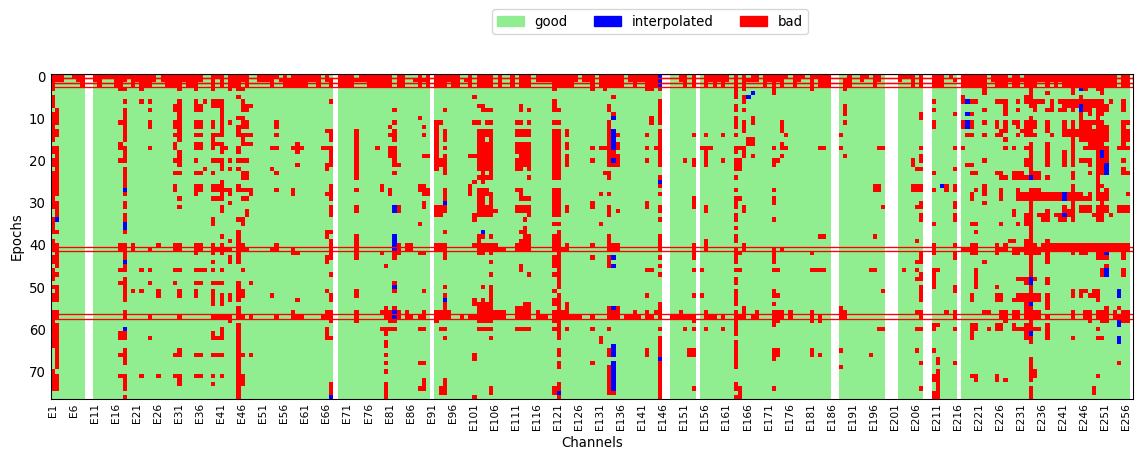

Additional 35 bad channels found:['E1', 'E2', 'E18', 'E31', 'E39', 'E41', 'E45', 'E46', 'E67', 'E73', 'E82', 'E94', 'E102', 'E103', 'E104', 'E105', 'E112', 'E114', 'E120', 'E121', 'E133', 'E134', 'E145', 'E163', 'E172', 'E207', 'E232', 'E233', 'E237', 'E243', 'E247', 'E249', 'E250', 'E251', 'E255']


In [8]:
from spectral.epochs import create_epochs, get_reject_log

#raw_annotated = raw_pyprep.copy()
epochs = create_epochs(raw_pyprep, overlap=1.5)

reject_log = get_reject_log(epochs, resample=125, n_interpolate=[1], consensus=[0.35])
reject_plot = reject_log.plot("vertical")


# Drop channels with more than 40% bad epochs
BADS_THRESHOLD = 0.35

bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)

bad_channel = bads.mean(axis=0)
# print(bad_channel)
epochs.info
channel_names = epochs.info["ch_names"]
bad_channels_by_epochs = [
    name for name, value in zip(channel_names, bad_channel) if value > BADS_THRESHOLD
]
print(
    f"Additional {len(bad_channels_by_epochs)} bad channels found:{
        bad_channels_by_epochs}"
)

#epochs.info["bads"].extend(bad_channels_by_epochs)

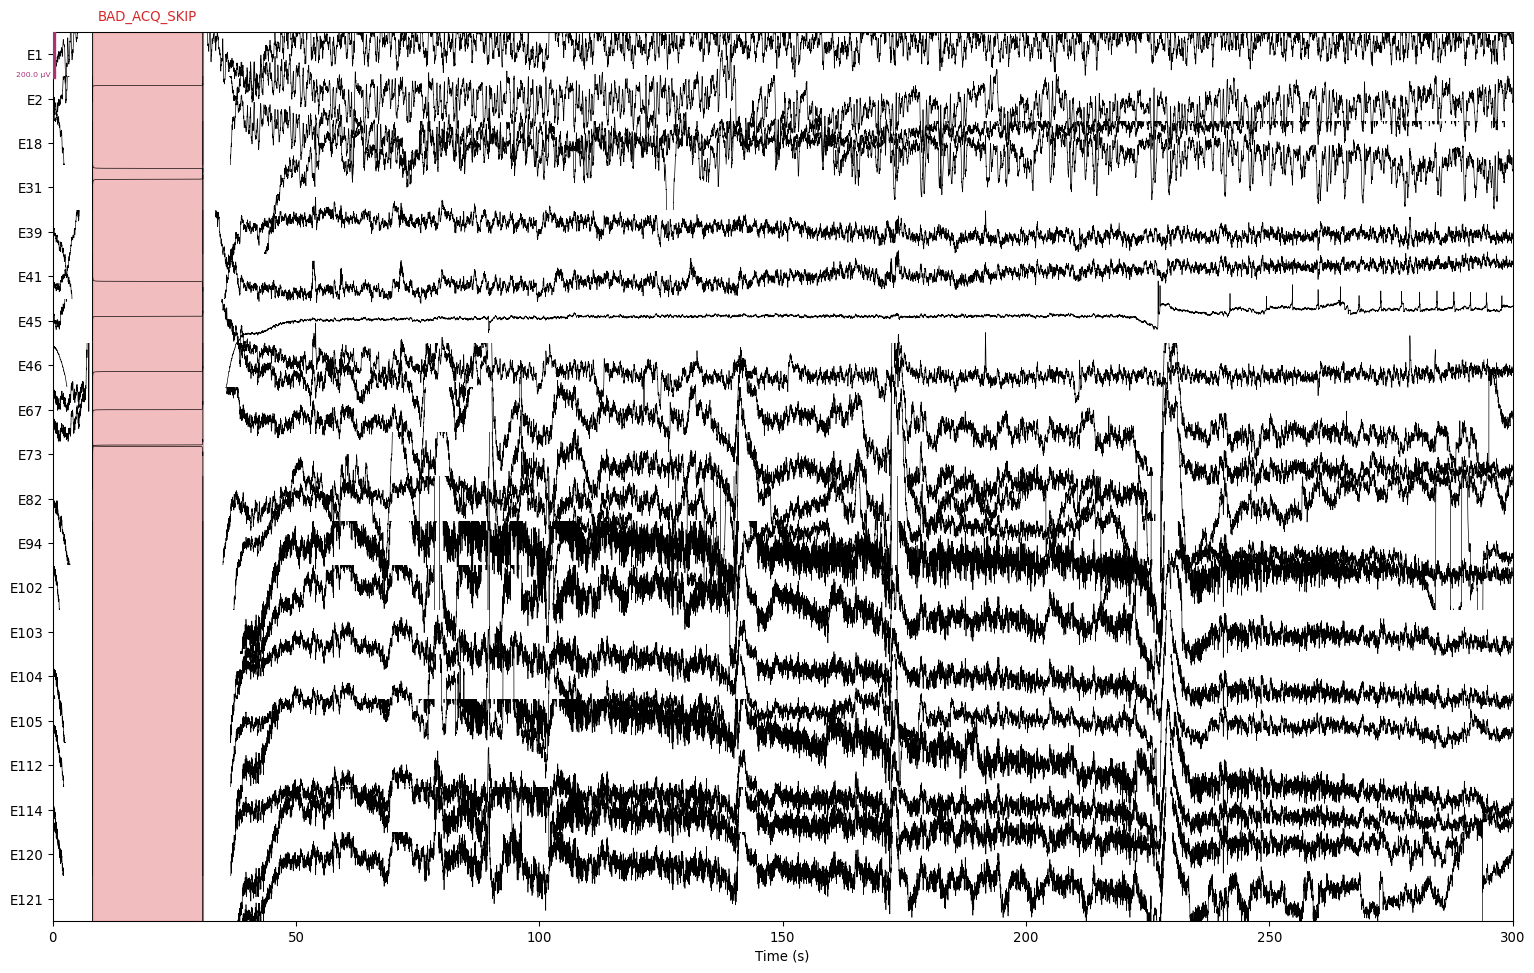

In [9]:
bad_channel_plot_additional = raw_pyprep.plot(
        picks=bad_channels_by_epochs,
        duration=300.0,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )

In [10]:
epochs_good = epochs[~reject_log.bad_epochs]
ica = compute_ica(epochs_good, n_components=0.99, method="picard")


Fitting ICA to data using 241 channels (please be patient, this may take a while)


Selecting by explained variance: 53 components


Fitting ICA took 20.7s.


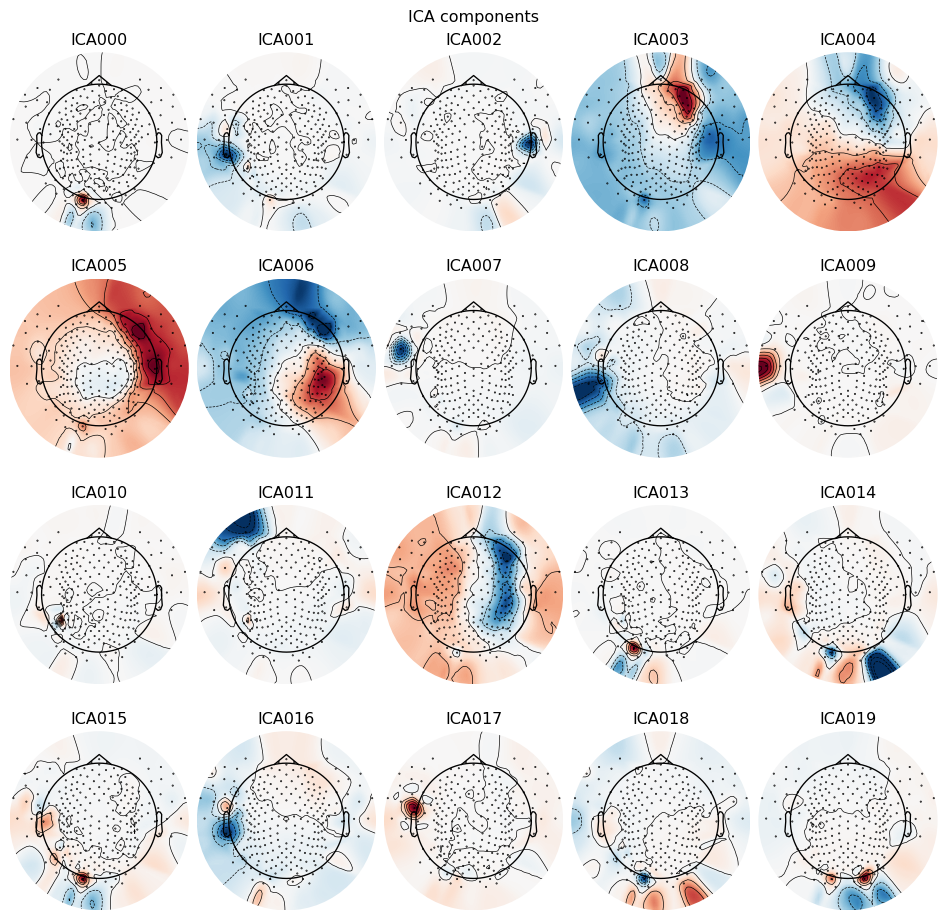

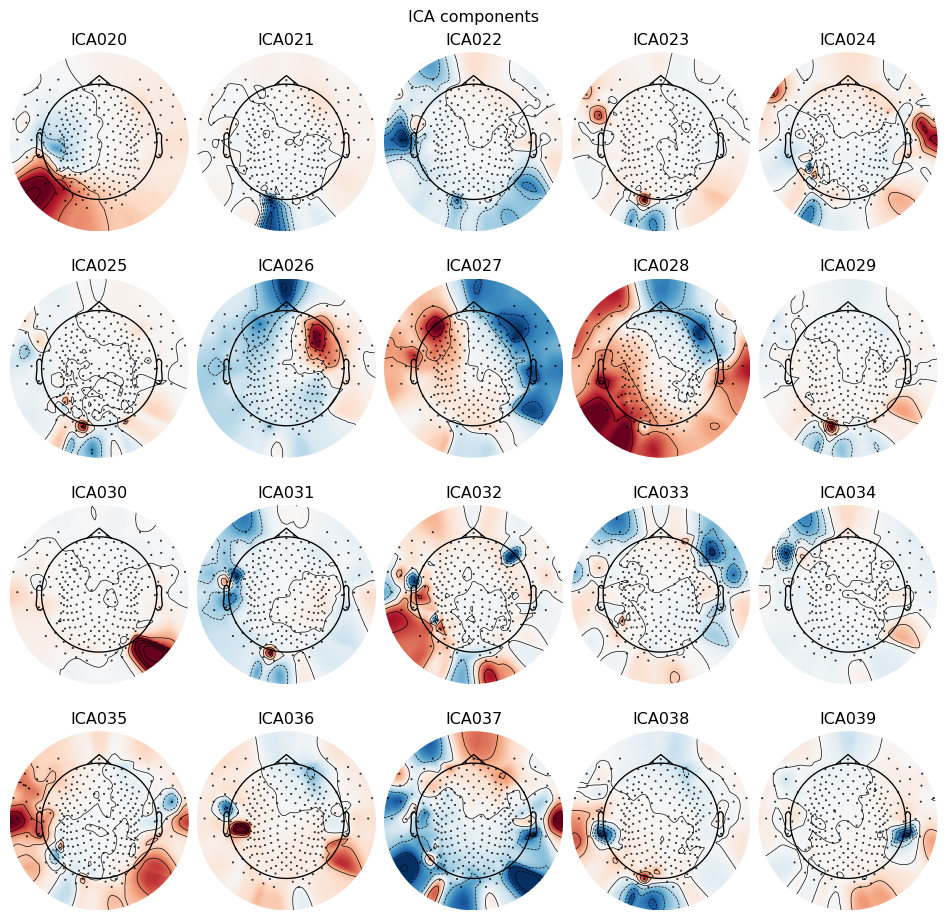

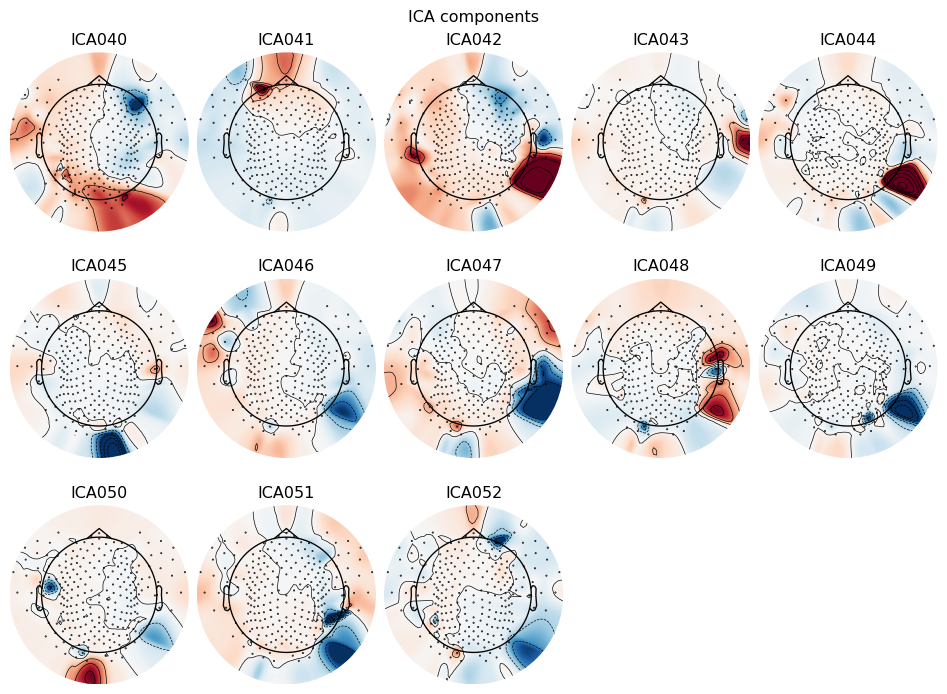

In [11]:
ica_plot_components = ica.plot_components()

Not setting metadata


72 matching events found


No baseline correction applied


0 projection items activated


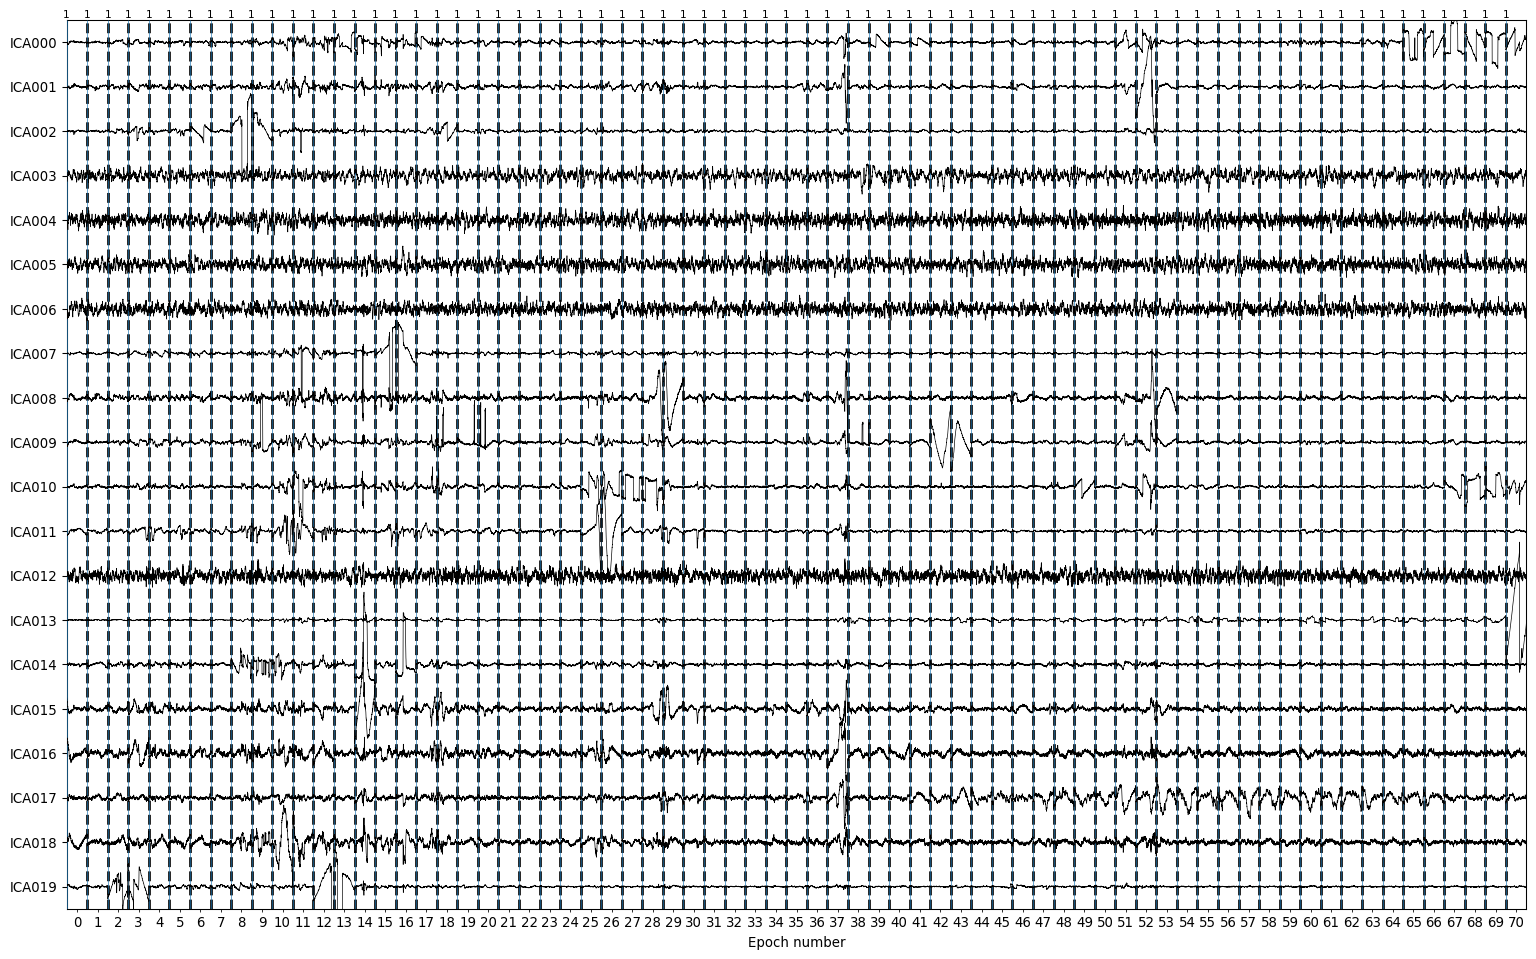

Not setting metadata


72 matching events found


No baseline correction applied


0 projection items activated


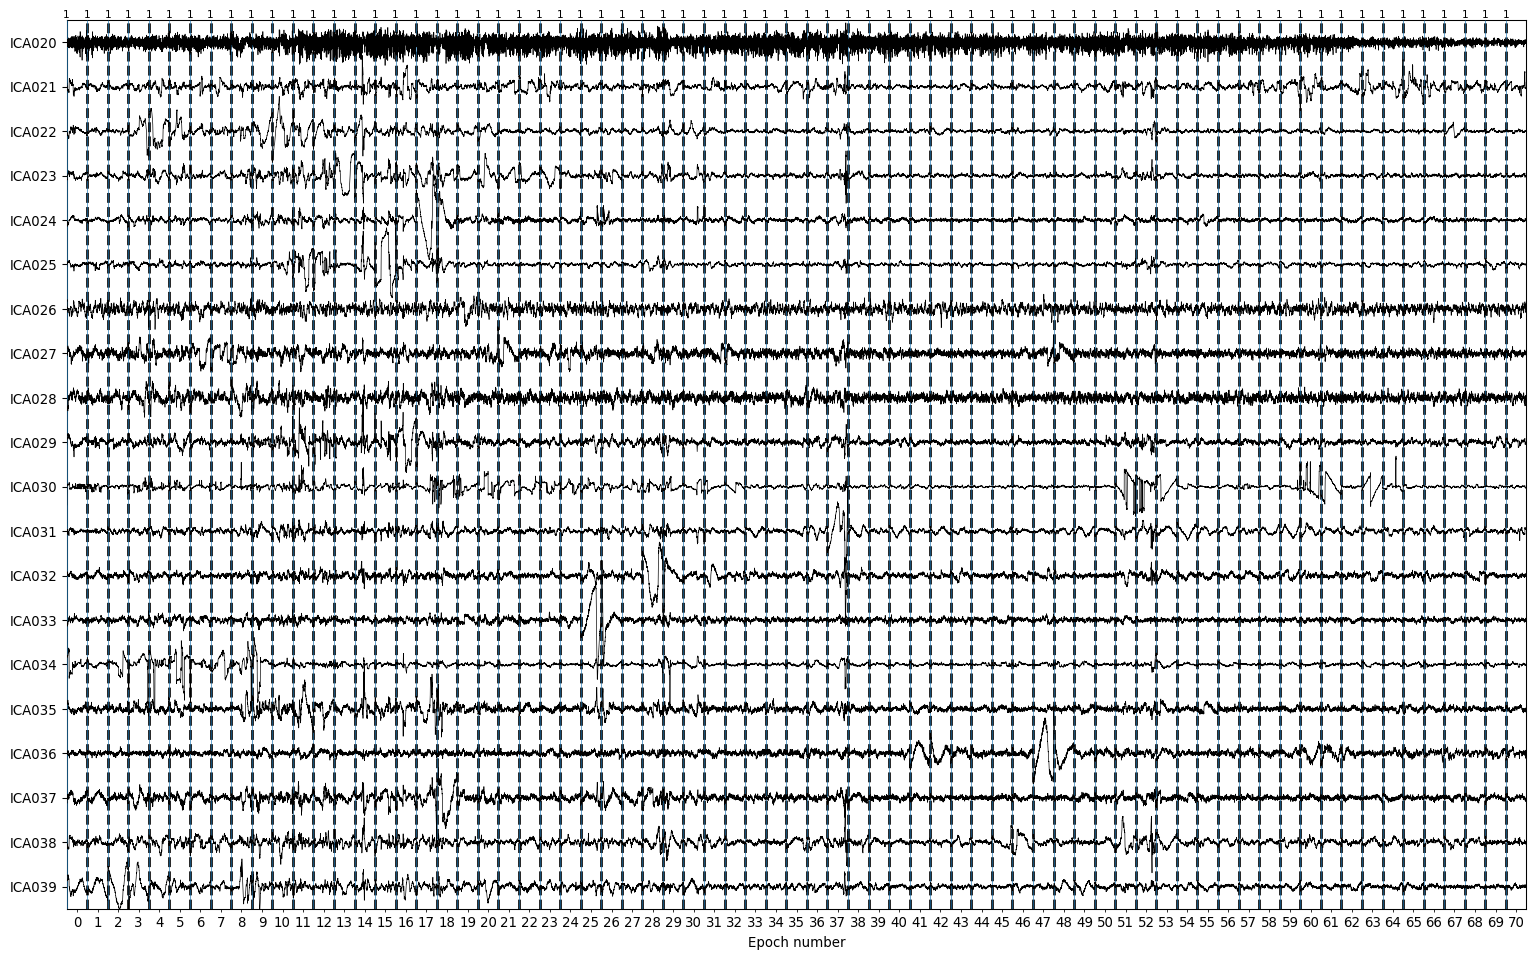

Not setting metadata


72 matching events found


No baseline correction applied


0 projection items activated


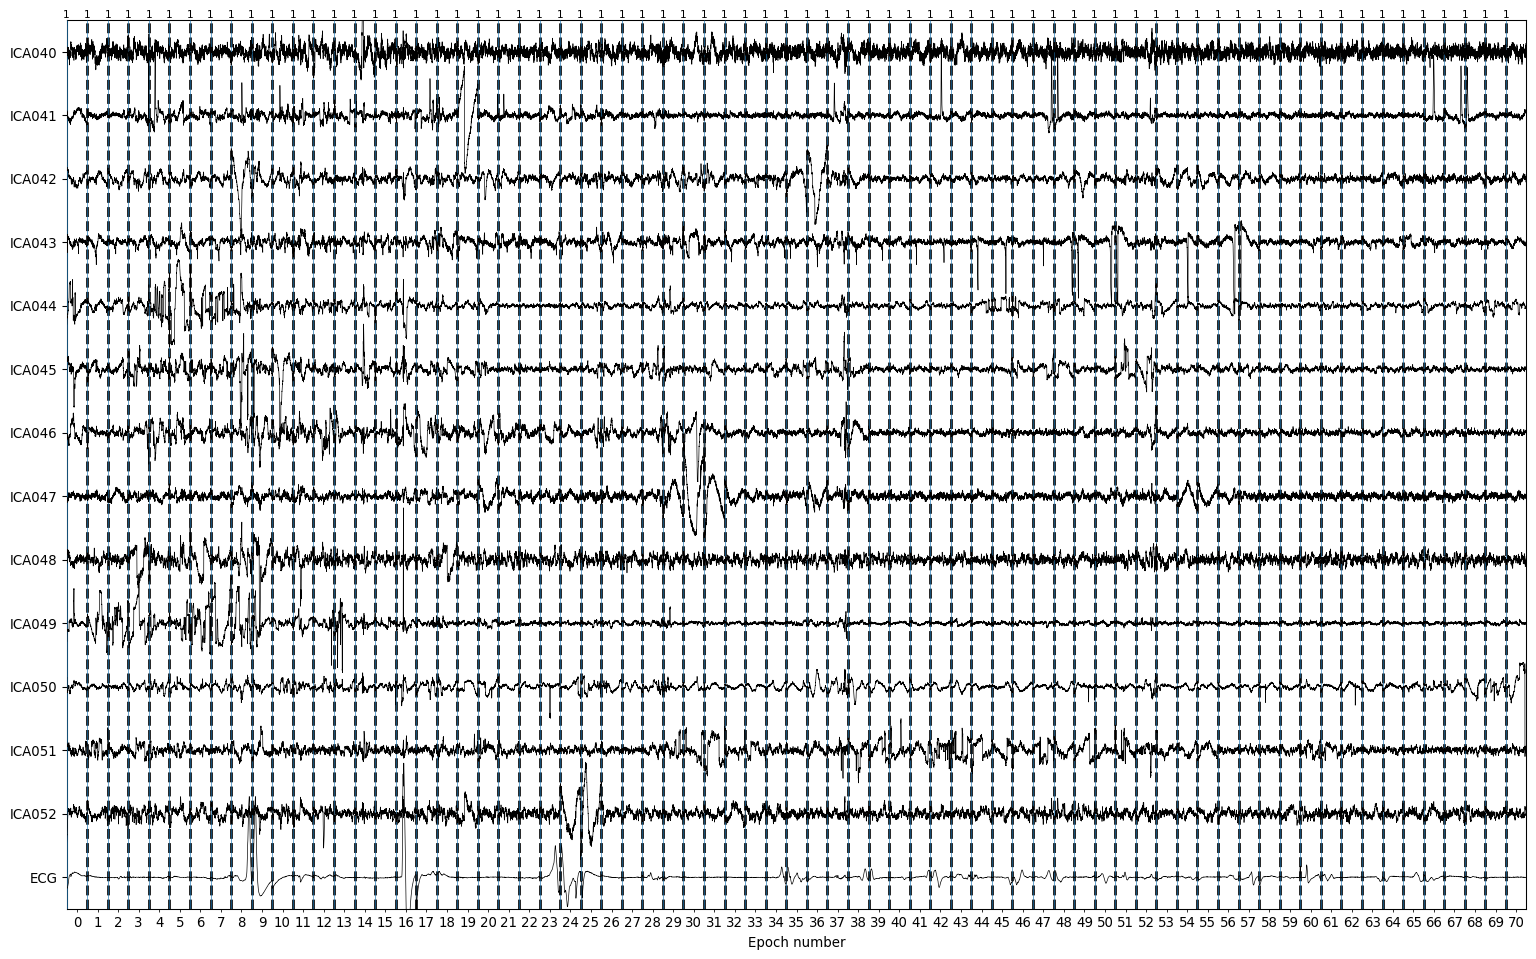

In [12]:
chunk_size = 20
chunks = [range(i, min(i + chunk_size, ica.n_components_)) for i in range(0, ica.n_components_, chunk_size)]

for chunk in chunks:
    ica_plot = ica.plot_sources(
                    epochs_good,
                    picks=chunk,
                    show_scrollbars=False,
                    start=0,
                    stop=len(epochs_good) - 1,
                )

# ICA editing


In [13]:
from mne.preprocessing import ICA

ica.save(f'{project_path}/analysis/sub-{subject}_my_ica_model-ica.fif', overwrite=True)
epochs_good.save(f'{project_path}/analysis/sub-{subject}_good_epochs-epo.fif', overwrite=True)

Overwriting existing file.


Writing ICA solution to /Users/daniel/PhD/Projects/psd-path/analysis/sub-152_my_ica_model-ica.fif...


Overwriting existing file.


Overwriting existing file.


In [14]:
ica_loaded = mne.preprocessing.read_ica(f'{project_path}/analysis/sub-{subject}_my_ica_model-ica.fif')
epochs_good =  mne.read_epochs(f'{project_path}/analysis/sub-{subject}_good_epochs-epo.fif')


Reading /Users/daniel/PhD/Projects/psd-path/analysis/sub-152_my_ica_model-ica.fif ...


Now restoring ICA solution ...


Ready.


Reading /Users/daniel/PhD/Projects/psd-path/analysis/sub-152_good_epochs-epo.fif ...


    Found the data of interest:


        t =       0.00 ...    5000.00 ms


        0 CTF compensation matrices available


Not setting metadata


72 matching events found


No baseline correction applied


0 projection items activated


In [15]:
from mne_icalabel.gui import label_ica_components

#gui = label_ica_components(epochs_good, ica)


In [16]:
# ica_plot = ica.plot_sources(eeg_data)
# Exclude blink artifact components (use Fp1 as EOG proxy)
clean_raw = mne.io.read_raw_fif(
    f"{project_path}/analysis/sub-{subject}_filtered_raw.fif", preload=True
)
# epochs_eog = mne.preprocessing.create_eog_epochs(raw=clean_raw, ch_name="EOG")
# eog_indices, eog_scores = ica.find_bads_eog(epochs_eog, ch_name="E31", threshold=2)
ecg_indices, ecg_scores = ica.find_bads_ecg(
    clean_raw, method="correlation", threshold="auto"
)
# ica.exclude = np.argwhere(abs(eog_scores) > 0.5).ravel().tolist()
if ecg_indices:
    # barplot of ICA component "EOG match" scores
    ica.plot_properties(clean_raw, picks=ecg_indices)

    # plot ICs applied to raw data, with ECG matches highlighted
    ecg_plot = ica.plot_sources(
        clean_raw,
        show_scrollbars=False,
        picks=ecg_indices,
        start=0,
        stop=300.0,
    )

Opening raw data file /Users/daniel/PhD/Projects/psd-path/analysis/sub-152_filtered_raw.fif...


    Range : 0 ... 75000 =      0.000 ...   300.000 secs


Ready.


Reading 0 ... 75000  =      0.000 ...   300.000 secs...


Omitting 5658 of 75001 (7.54%) samples, retaining 69343 (92.46%) samples.


Omitting 5658 of 75001 (7.54%) samples, retaining 69343 (92.46%) samples.


... filtering ICA sources


Setting up band-pass filter from 8 - 16 Hz


FIR filter parameters


---------------------


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hann window


- Lower passband edge: 8.00


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)


- Upper passband edge: 16.00 Hz


- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)


- Filter length: 2500 samples (10.000 s)


... filtering target


Setting up band-pass filter from 8 - 16 Hz


FIR filter parameters


---------------------


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hann window


- Lower passband edge: 8.00


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)


- Upper passband edge: 16.00 Hz


- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)


- Filter length: 2500 samples (10.000 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [17]:
#exclude = [1, 9, 45]
exclude =  []

In [18]:
if exclude:
    ica.exclude = exclude
    epochs_clean_manual = ica.apply(epochs.copy(), exclude=ica.exclude)
    epochs_clean_manual.save(
    f"{project_path}/sub-{subject}_clean_ica-manual-epo.fif", overwrite=True
    )

# Cleaned epochs


In [19]:
from pathlib import Path
import autoreject
# Define the file path
cleaned_epochs = Path(f"{project_path}/analysis/sub-{subject}_clean_ica-manual-epo.fif")

# Check if the file exists
if cleaned_epochs.exists():
    epochs = mne.read_epochs(str(cleaned_epochs), preload=True)
else:
    print(f"File {project_path} does not exist, loading epochs before ICA.")
    epochs = mne.read_epochs(
    f"{project_path}/analysis/sub-{subject}_good_epochs-epo.fif", preload=True
)

File /Users/daniel/PhD/Projects/psd-path does not exist, loading epochs before ICA.
Reading /Users/daniel/PhD/Projects/psd-path/analysis/sub-152_good_epochs-epo.fif ...


    Found the data of interest:


        t =       0.00 ...    5000.00 ms


        0 CTF compensation matrices available


Not setting metadata


72 matching events found


No baseline correction applied


0 projection items activated


fitting finished


Dropped 1 epoch: 37


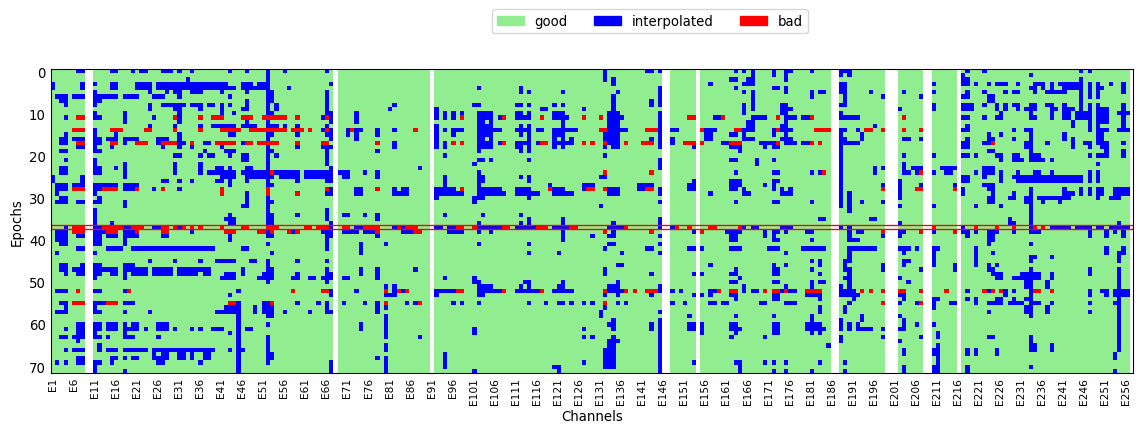

In [20]:
auto_reject_pre_ica = autoreject.AutoReject(
    n_interpolate=[1, 2, 4, 8, 32, 64, 128],
    n_jobs=-1,
    random_state=100,
    thresh_method="bayesian_optimization",
    verbose=False,
    # n_interpolate=np.array([0]),
    # consensus=0.8,
).fit(epochs[:20])
print("fitting finished")
epochs_ar, reject_log = auto_reject_pre_ica.transform(epochs, return_log=True)


# depending of the resampling - different number of epochs are rejected

reject_plot = reject_log.plot("vertical")

Setting channel interpolation method to {'eeg': 'spline'}.


Interpolating bad channels.


    Automatic origin fit: head of radius 95.5 mm


Computing interpolation matrix from 241 sensor positions


Interpolating 15 sensors


No projector specified for this dataset. Please consider the method self.add_proj.


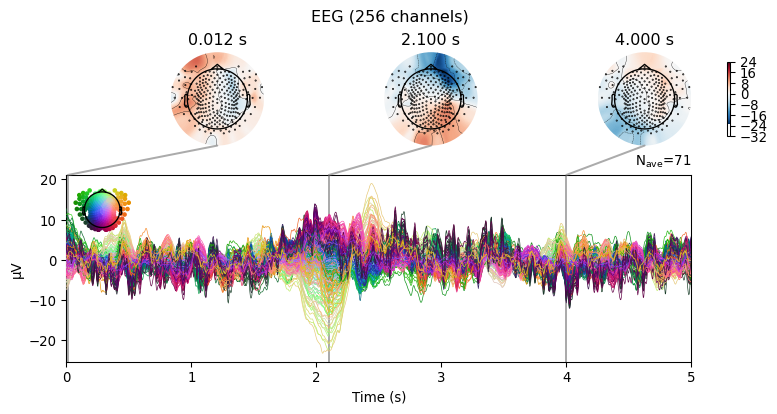

Effective window size : 5.004 (s)


Plotting power spectral density (dB=True).


Averaging across epochs...


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:55: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  ).plot(average=False, picks="eeg", exclude="bads", show=False)


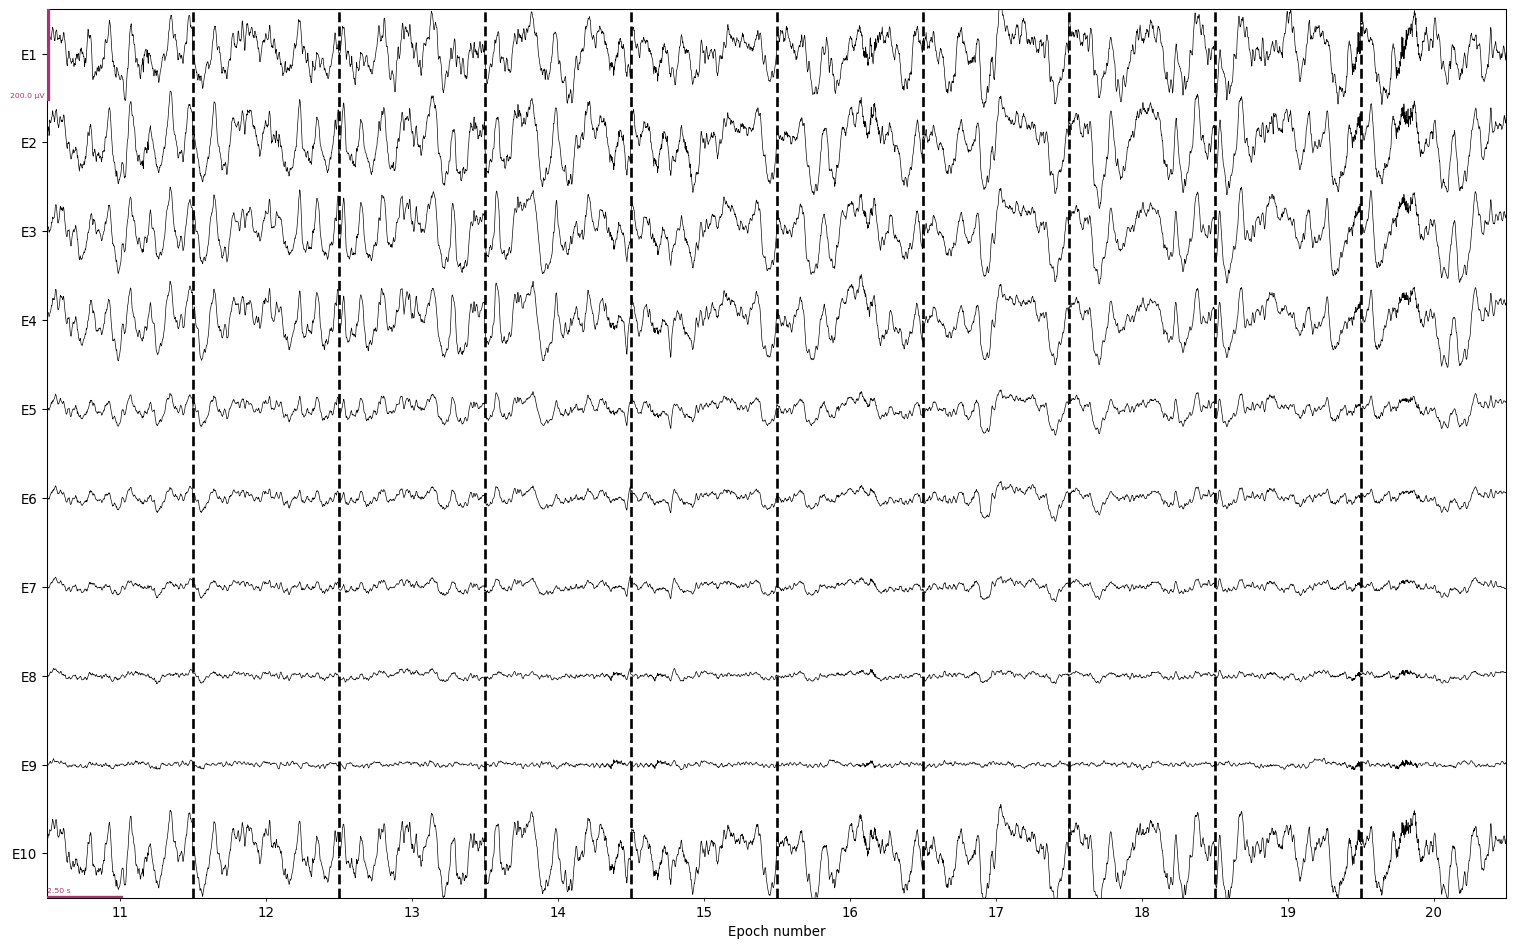

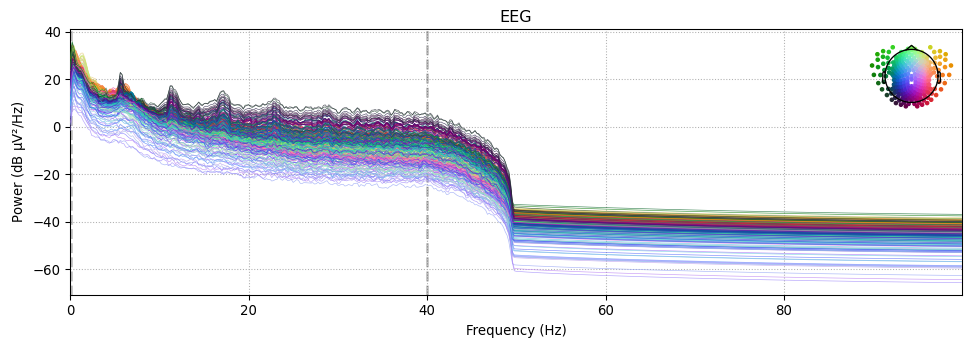

In [21]:
epochs_interpolated = epochs_ar.copy().interpolate_bads(exclude=["VREF"])
plot_epochs(
    epochs_interpolated, figures_path, subject, stage="final_interpolared_epochs"
)

## Save to EEGlab


In [22]:
from eeglabio.utils import export_mne_epochs

try:
    export_mne_epochs(
        epochs_interpolated,
        f"{project_path}/analysis/sub-{subject}_clean_epochs_ica-manual_interpolared-epo.set",
    )
except Exception as e:
    print(e)

/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/eeglabio/utils.py:169: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  export_set(fname, inst.get_data(), inst.info['sfreq'], inst.events,
/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/eeglabio/epochs.py:143 EEGLABIO: WARNING: Events doesn't meet the requirement of at least one event per epoch, adding dummy events


# Specparam


In [23]:
from specparam.plts.spectra import plot_spectra
from specparam import SpectralGroupModel


fg = SpectralGroupModel(
    peak_width_limits=[1, 6],
    min_peak_height=0.15,
    peak_threshold=2.0,
    max_n_peaks=6,
    verbose=False,
)

## Specparam for non-augmented data


    Using multitaper spectrum estimation with 7 DPSS windows


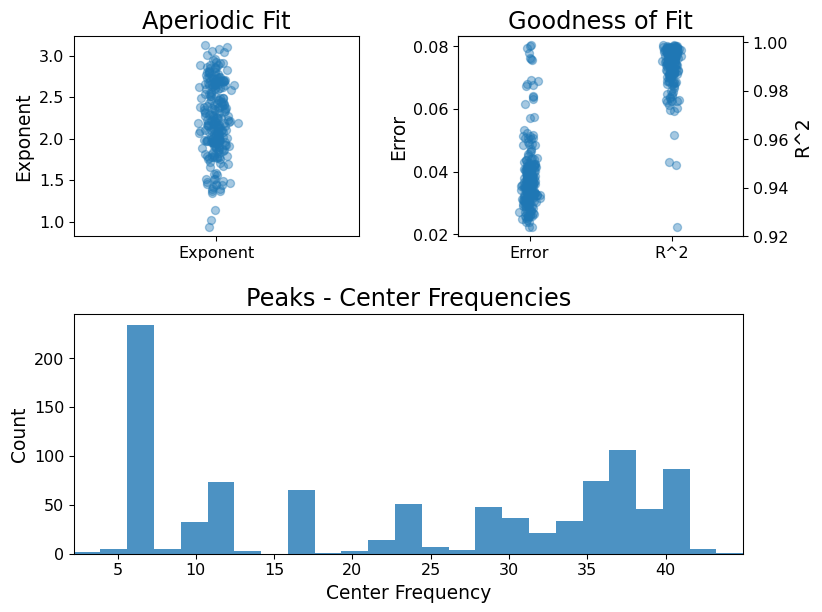

In [24]:
psd = epochs.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

# Define the frequency range to fit
freq_range = [2, 45]
fg.fit(freqs, spectra, freq_range)
fg.plot()

# `Specparam` for augmented data


    Using multitaper spectrum estimation with 7 DPSS windows


Subject 152 done


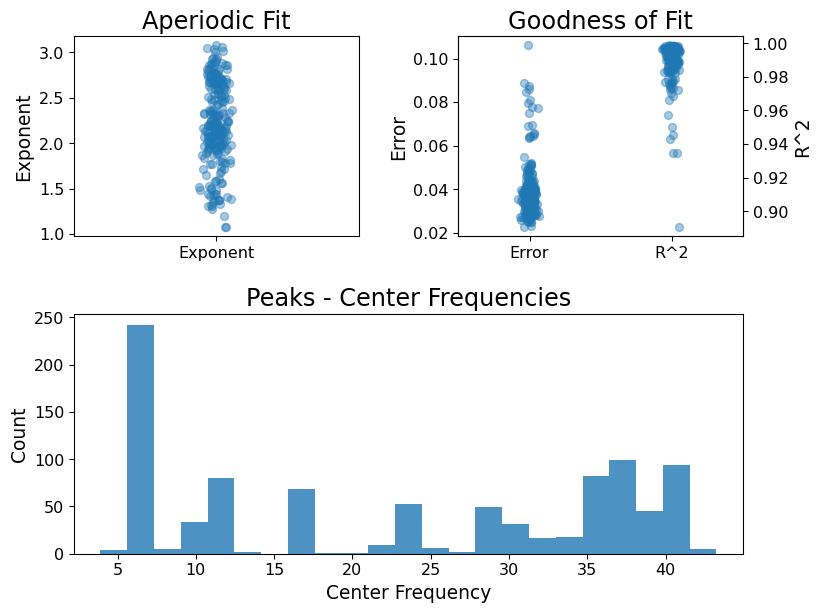

In [25]:
psd = epochs_ar.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

# Define the frequency range to fit
freq_range = [2, 45]
fg.fit(freqs, spectra, freq_range)
fg.plot()

df = specparam2pandas(fg)
df.to_csv(f"{specparam_path}/sub-{subject}-specparam.csv", index=False)
print(f"Subject {subject} done")